# Definición de la arquitectura

Proyecto: Estimación del precio de criptomonedas en función del sentimiento global y el histórico de la misma. La estimación se realizará por hora a tiempo real.Se darán prediciones a la hora siguiente y a 24 horas vista.

## Esquema




1.   Dataset con tweets históricos con la palabra clave bitcoin/otra moneda

 1.1. Análisis exploratorio previo

 1.2. Pipeline preprocesado

 1.3.  División train/test

 1.4. Entrenamiento del modelo

 1.5. Análisis métricas/ elección del modelo

 1.6. Predicción check modelo

 1.7. Descarga adicional de tweets debido a no disponer de datos para todas las horas en el dataset inicial

 1.8. Predicción para todo el dataset ampliado, obtención de probabilidad asociada al sentimiento.

2.   Dataset histórico criptomonedas.

 2.1. Análisis exploratorio (volatilidad,max, min,...)

3. Modelo predicción precio/movimientos cripto

  3.1. Determinación del sentimiento global a partir de las predicciones del punto 1.8 ( variable explicativa del modelo)

  3.2. Creación del dataset para la predicción del precio/movimiento

  3.3. División train/test (definir que ventana usaremos de test)

  3.4. Entrenamiento del modelo

  3.5. Análisis de métricas elección del modelo

4. Extracción de datos a tiempo real Twitter

  4.1. Recoger los tweets en tiempo real

  4.2. Aplicar el modelo y obtener el sentimiento de los tweets que van llegando

  4.3. Guardamos los resultados en BigQuery

5. Sentimiento Global en la ventana de tiempo determinada

  5.1. Aplicar el algoritmo para ventanas de tiempo establecidas

  5.2. Guardar los resultados en BigQuery

6. Extracción de datos a tiempo (lo más real posible) de la criptomoneda

  6.1. Recoger a tiempo real los datos de la moneda

  6.2. Guardar los resultados en BigQuery

7. Predicción del posible precio/movimiento de la criptomoneda.

  7.1. Cada ventana temporal con los datos nuevos de twitter se estimará el posible precio/movimiento de la cripto.

    7.1.1. Predición a una hora
    
    7.1.2. Predición a 24 horas

  7.2. Comparación de la previsión con el dato real cuando éste llegue una hora después.

8. Dashbord de visualización a tiempo real de las predicciones, comparación con los resultados reales, etc




 




## Parte en Bach

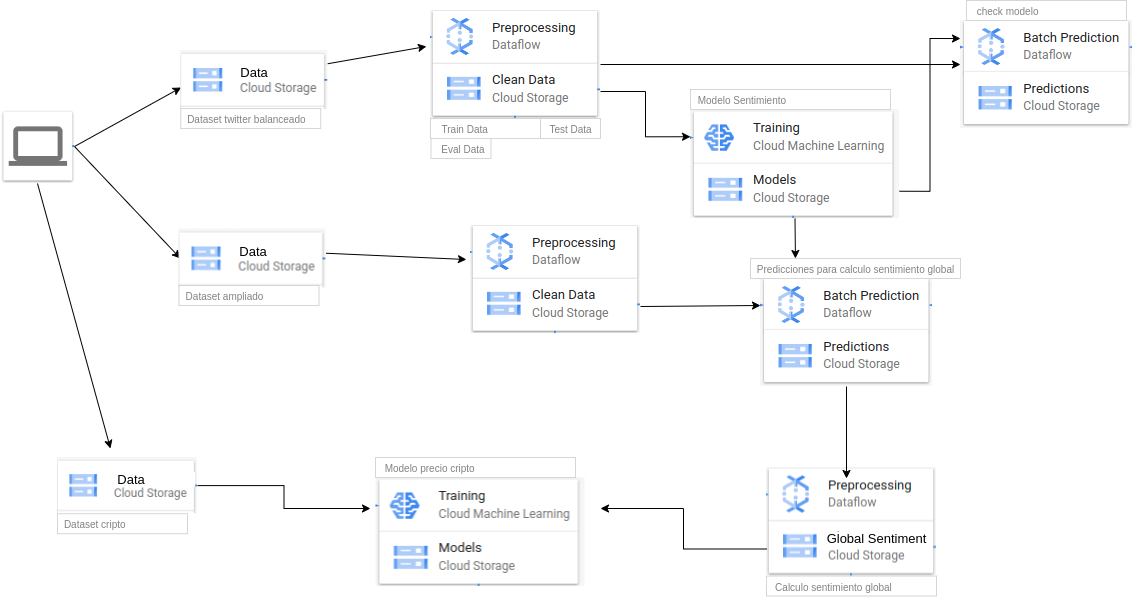

La parte batch engloba en primer lugar la creación del modelo de predicción del sentimiento. Para eso, en primer lugar se guardará en Cloud Storage el dataset de tweets con su sentimiento asignado. Dicha etiqueta ha sido asignada mediante VADER.

El dataset contiene 3 etiquetas ( POSITIVO,NEGATIVO,NEUTRAL),y además no está balanceado. 

Para el entrenamiento nos quedaremos solo con las etiquetas positivas y negativas con el objetivo de obtener una probabilidad como resultado y no la etiqueta más probable. Por otro lado, dado que está desbalanceado, de forma aleatoria, nos quedaremos con un porcentaje de los tweets positivos tal que supongan el 60% de la muestra y un 40% los negativos. Este dataset es el que tendremos en el bucket.

Tras el analisis exploratorio, nos dimos cuenta que no contabamos con tweets para todas las horas. Elemento fundamental para posteriormente calcular el sentimiento global asignando una probabilidad a cada hora, y que será un input en el modelo de predicción final. Por ese motivo, se lleva a cabo un incremento del dataset, haciendo scraping mediante la librería snscraper.

Dicho dataset junto con el anterior dataset en bruto, lo guardaremos en Cloud storage para posteriormente utilizarlo para el cálculo del sentimiento global.

Para ambos dataset se realizará un preprocesado, en el que se incluye la limpieza de los datos, y su tokenización, todo esto se llevará a cabo mediante un job en Dataflow, cuyo resultado se guardará de nuevo en Cloud Storage. Para el caso del dataset balanceado que usaremos para entrenar, el job lo divide entre train, test y validación.

Con el dataset limpio se entrenará el modelo, utilizando metodologías NLP en Cloud Machine Learning cuyos modelos guardaremos para su uso posterior.

Se utilizarán dichos modelos para obtener predicciones, y validar el modelo obteniendo un conjunto de métricas.

Una vez que tenemos el modelo, y se ha evaluado su calidad, aplicaremos el modelo al dataset  completo. Esto de nuevo se realizará con un job de Dataflow.

De nuevo con el modelo generado, y el con este último dataset, se hará un procesado de los mismos con el objetivo de obtener una ventana de sentimiento global (ventanas de una hora). Dicho procesamiento se llevará a cabo mediante el uso de Dataflow. Y el resultado se guardará de nuevo en el bucket. 

Paralelamente, se cargará el dataset del histórico de los movimientos de la criptomoneda, dicho dataset no requiere ningún tratamiento adicional, ya que la exploración de los datos ya se habrá realizado previamente.

Se creará un dataset con la información del sentimiento y el histórico de precios de la cripto.

Mediante la herramienta de Cloud Machine Learning se generarán modelos de ML/Deep learning teniendo en cuenta que se trata de una serie temporal. Con el dataset de test se llevarán a cabo las predicciones que nos permitirán validar la calidad del modelo.

El modelo final se guardará para su uso posterior.




# Parte Streaming

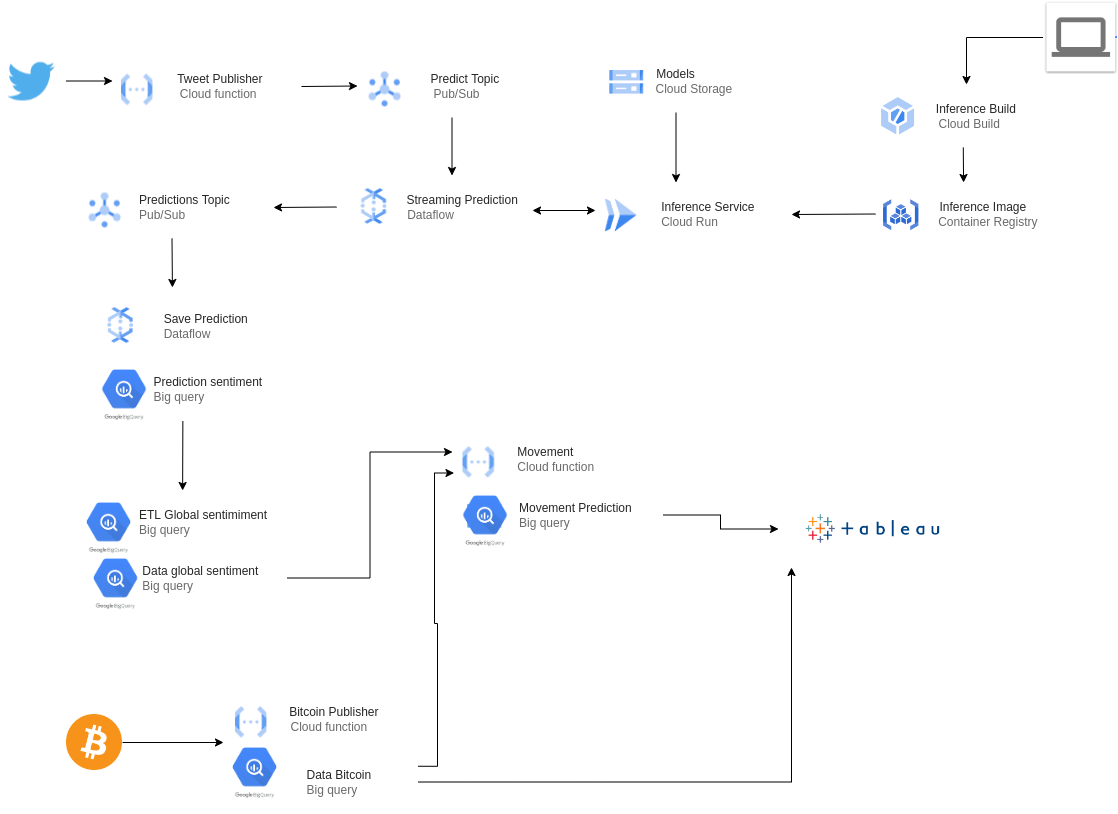

En primer lugar, con una Cloud Function recogemos los datos a tiempo real que van llegando de twitter. Debido al límite del API, se lanzará cada 5 minutos con Cloud Schedule, con el objetivo de tener tweets distribuidos en el tiempo. Esto hace que tengamos una limitación debido a la imposibilidad de acceder al conjunto completo de tweets acerca de un tema. 

Estos tweets los recogemos en un topic, y mediante un job de Dataflow se aplicará la predicción de acuerdo con el modelo de sentimiento obtenido en bach que lo tendremos desplegado en un servidor mediante un microservicio (utilizando Inference Services) y serán recogidos en otro topic.
Mediante otro job de Dataflow guardaremos en BigQuery.

Cada hora,se activará una consulta programada en BigQuery (ETL), que generará la métrica de sentimiento global de esa hora, y guardaremos el resultado en otra tabla en BigQuery.

De nuevo cada hora una cloud function descargará el dato de cierre de la criptomoneda de la última hora. Y guardaremos en otra tabla de BigQuery.
Datos que usaremos para la predicción de la siguiente hora y para ver el error cometido en la predicción anterior.

Con toda la informacoón actualizada otra Cloud Function se encargará de leer los datos del pasado y generar una predición. Este proceso en paralelo se hará dos veces ya que se estimará el precio en el corto plazo, a una hora y vista y por otro lado se dará también una predicción más a largo plazo (a 24 horas vista). La predicción se guardará de nuevo en Big Query.


Por último, tanto la predicción como el dato real actualizan se mostrará en un dashboard.